In [12]:
# 1. Imports
# -------------------------
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve, 
    precision_recall_curve, f1_score, confusion_matrix, 
    accuracy_score, precision_score, recall_score
)
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline

# ALL REQUIRED MODELS
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# BONUS MODEL
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path

sns.set(style='whitegrid')
print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


In [13]:
# -------------------------
# 2. Set Paths (Works on Mac, Windows, Linux)
# -------------------------
from pathlib import Path

# Universal path detection
project_root = Path.cwd()
if project_root.name == "notebooks":
    project_root = project_root.parent

processed_folder = project_root / "data" / "processed"
models_folder = project_root / "models"
models_folder.mkdir(exist_ok=True)

train_path = str(processed_folder / "train.csv")
test_path = str(processed_folder / "test.csv")
y_train_path = str(processed_folder / "y_train.csv")
y_test_path = str(processed_folder / "y_test.csv")

X_train = pd.read_csv(train_path)
X_test = pd.read_csv(test_path)
y_train = pd.read_csv(y_train_path).squeeze()
y_test = pd.read_csv(y_test_path).squeeze()

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"Class distribution: {y_train.value_counts().to_dict()}")

X_train: (1176, 55), X_test: (294, 55)
Class distribution: {0: 986, 1: 190}


In [14]:
# -------------------------
# 3. Feature Selection: Mutual Information
# -------------------------
mi = mutual_info_classif(X_train, y_train, random_state=42)
mi_series = pd.Series(mi, index=X_train.columns).sort_values(ascending=False)
top_features_mi = mi_series.head(20).index.tolist()  # keep top 20 features
print("Top 20 features by mutual information:")
print(top_features_mi)

# Reduce datasets to top features
X_train_fs = X_train[top_features_mi]
X_test_fs = X_test[top_features_mi]

Top 20 features by mutual information:
['JobRole_Research Director', 'MonthlyIncome', 'OverTime_Yes', 'StockOptionLevel', 'Age', 'JobInvolvement', 'YearsInCurrentRole', 'TotalWorkingYears', 'Department_Human Resources', 'PerformanceRating', 'Gender_Male', 'TrainingTimesLastYear', 'YearsAtCompany', 'Gender_Female', 'JobRole_Manufacturing Director', 'YearsSinceLastPromotion', 'JobLevel', 'HourlyRate', 'YearsWithCurrManager', 'Department_Research & Development']


In [15]:
# -------------------------
# 4. Define Models - ALL REQUIRED MODELS
# -------------------------
models = {
    # ===== REQUIRED MODELS  =====
    "LogisticRegression": LogisticRegression(
        class_weight='balanced', 
        max_iter=1000, 
        random_state=42
    ),
    
    "DecisionTree": DecisionTreeClassifier(
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=10,
        class_weight='balanced',
        random_state=42
    ),
    
    "RandomForest": RandomForestClassifier(
        n_estimators=200, 
        class_weight='balanced', 
        random_state=42,
        n_jobs=-1
    ),
    
    "KNN": KNeighborsClassifier(
        n_neighbors=7,
        weights='distance',
        metric='euclidean',
        n_jobs=-1
    ),
    
    # ===== BONUS MODEL =====
    "SVM": SVC(
        kernel='rbf', 
        probability=True, 
        class_weight='balanced', 
        random_state=42
    )
}

print("="*60)
print("MODELS DEFINED")
print("="*60)
print(f"\n✓ Total models: {len(models)}")
print(f"\nRequired models (4):")
print("  1. Logistic Regression")
print("  2. Decision Tree")
print("  3. Random Forest")
print("  4. K-Nearest Neighbors (KNN)")
print(f"\nBonus models (1):")
print("  5. Support Vector Machine (SVM)")
print("\n" + "="*60)

MODELS DEFINED

✓ Total models: 5

Required models (4):
  1. Logistic Regression
  2. Decision Tree
  3. Random Forest
  4. K-Nearest Neighbors (KNN)

Bonus models (1):
  5. Support Vector Machine (SVM)



In [16]:
# -------------------------
# 5. Train, Evaluate, Save Models
# -------------------------
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_fs, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_fs)
    y_proba = model.predict_proba(X_test_fs)[:,1] if hasattr(model, "predict_proba") else model.decision_function(X_test_fs)
    
    # Metrics
    roc_auc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    print(f"{name} ROC-AUC: {roc_auc:.4f}, F1: {f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Save model
    model_path = os.path.join(models_folder, f"{name}_model.pkl")
    joblib.dump(model, model_path)
    print(f"{name} saved to {model_path}")
    
    results[name] = {"model": model, "roc_auc": roc_auc, "f1": f1}


Training LogisticRegression...
LogisticRegression ROC-AUC: 0.7822, F1: 0.4371
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.71      0.81       247
           1       0.32      0.70      0.44        47

    accuracy                           0.71       294
   macro avg       0.62      0.71      0.62       294
weighted avg       0.83      0.71      0.75       294

LogisticRegression saved to /Users/benjaminnguyen/Employee_attrition/models/LogisticRegression_model.pkl

Training DecisionTree...
DecisionTree ROC-AUC: 0.7292, F1: 0.3866
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.80      0.84       247
           1       0.32      0.49      0.39        47

    accuracy                           0.75       294
   macro avg       0.61      0.65      0.62       294
weighted avg       0.80      0.75      0.77       294

DecisionTree saved to /Users/benjaminnguyen/Emplo


MODEL PERFORMANCE COMPARISON

             Model  ROC-AUC  F1-Score
               SVM 0.777500  0.481203
LogisticRegression 0.782152  0.437086
      DecisionTree 0.729219  0.386555
               KNN 0.694461  0.290323
      RandomForest 0.749806  0.222222



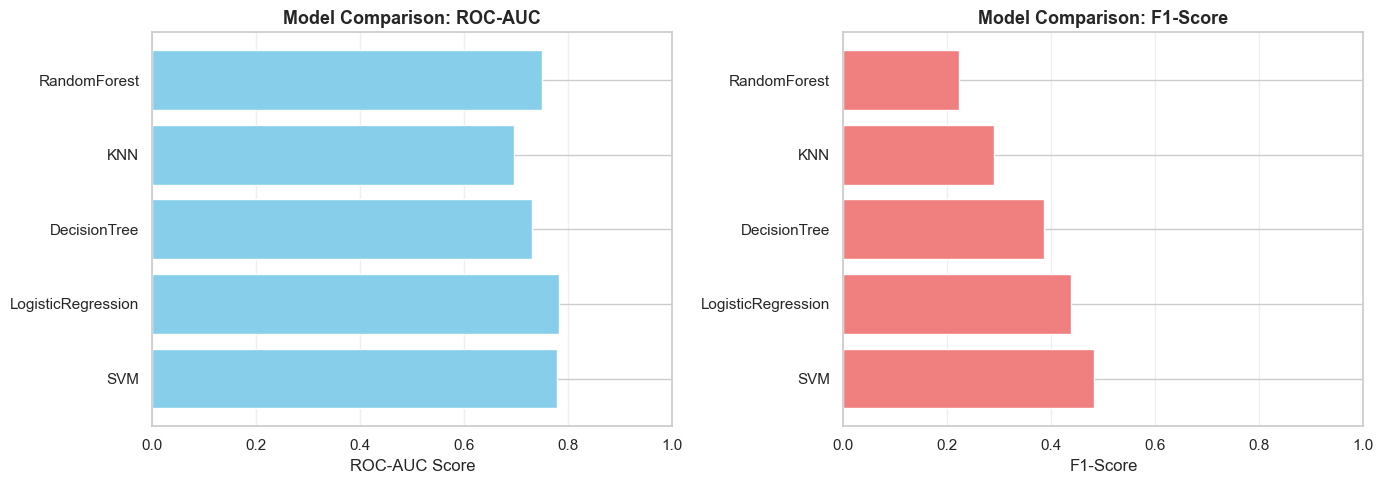


🏆 BEST MODEL: SVM
   F1-Score: 0.4812

✓ All 5 models trained and compared!
✓ Comparison saved to /Users/benjaminnguyen/Employee_attrition/models/model_comparison.csv


In [17]:
# -------------------------
# 6. Model Comparison Table
# -------------------------
print("\n" + "="*70)
print("MODEL PERFORMANCE COMPARISON")
print("="*70)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'ROC-AUC': [results[m]['roc_auc'] for m in results.keys()],
    'F1-Score': [results[m]['f1'] for m in results.keys()]
}).sort_values('F1-Score', ascending=False)

print("\n" + comparison_df.to_string(index=False))
print("\n" + "="*70)

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC-AUC comparison
axes[0].barh(comparison_df['Model'], comparison_df['ROC-AUC'], color='skyblue')
axes[0].set_xlabel('ROC-AUC Score', fontsize=12)
axes[0].set_title('Model Comparison: ROC-AUC', fontsize=13, fontweight='bold')
axes[0].set_xlim([0, 1])
axes[0].grid(axis='x', alpha=0.3)

# F1-Score comparison
axes[1].barh(comparison_df['Model'], comparison_df['F1-Score'], color='lightcoral')
axes[1].set_xlabel('F1-Score', fontsize=12)
axes[1].set_title('Model Comparison: F1-Score', fontsize=13, fontweight='bold')
axes[1].set_xlim([0, 1])
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(models_folder / 'model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Save comparison table
comparison_df.to_csv(models_folder / 'model_comparison.csv', index=False)

# Print best model
best_model_name = comparison_df.iloc[0]['Model']
best_f1 = comparison_df.iloc[0]['F1-Score']
print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   F1-Score: {best_f1:.4f}")
print(f"\n✓ All {len(models)} models trained and compared!")
print(f"✓ Comparison saved to {models_folder / 'model_comparison.csv'}")


In [18]:
# -------------------------
# 6. Permutation Feature Importance (Example for RandomForest)
# -------------------------
rf_model = results["RandomForest"]["model"]
perm_importance = permutation_importance(rf_model, X_test_fs, y_test, n_repeats=10, random_state=42)
perm_df = pd.DataFrame({"feature": X_train_fs.columns, "importance": perm_importance.importances_mean})
perm_df = perm_df.sort_values(by="importance", ascending=False)
print("Permutation feature importance (RandomForest):")
print(perm_df.head(10))

Permutation feature importance (RandomForest):
                              feature  importance
2                        OverTime_Yes    0.011224
11              TrainingTimesLastYear    0.007143
5                      JobInvolvement    0.006463
19  Department_Research & Development    0.002041
15            YearsSinceLastPromotion    0.001701
8          Department_Human Resources    0.000000
9                   PerformanceRating    0.000000
0           JobRole_Research Director   -0.000340
10                        Gender_Male   -0.000340
17                         HourlyRate   -0.000680


In [19]:
# -------------------------
# 7. SHAP Analysis for Final Model
# -------------------------
final_model = results["RandomForest"]["model"]  # pick best by business metric, e.g., recall/F1

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test_fs)
shap.initjs()

# Global importance
sv = shap_values[1] if isinstance(shap_values, list) else shap_values
shap.summary_plot(sv, X_test_fs, plot_type="bar")

# Detailed summary
shap.summary_plot(sv, X_test_fs)

NameError: name 'shap' is not defined

In [ ]:
# -------------------------
# 8. Business Insights
# -------------------------
top_features = perm_df.head(5)["feature"].tolist()
print("Top features driving attrition risk:")
for f in top_features:
    median_val = X_test_fs[f].median()
    print(f"{f}: median value = {median_val}, higher/lower values may impact attrition risk")
